#Урок 5. Рекуррентные нейронные сети


__1) Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?__






In [74]:
# Импорт необходимых библиотек
import numpy as np 

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 

from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [ ]:
# Разбор текста - Токенизация
####################################################################################
# Создаем объект для токенизации
tokenizer = Tokenizer(   num_words=10000)
!wget 'https://drive.google.com/uc?export=download&id=1bo7wZvtSCz680uNrGvQCPtOKlVMbkxBE' -O pushkin_skazka.txt
data = open('pushkin_skazka.txt').read()
#Читаем текст
corpus = data.lower().split("\n")

--2022-06-24 14:53:14--  https://drive.google.com/uc?export=download&id=1bo7wZvtSCz680uNrGvQCPtOKlVMbkxBE
Resolving drive.google.com (drive.google.com)... 74.125.199.101, 74.125.199.139, 74.125.199.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.199.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h1ksksig8i7u9angqtacrlb9c6uvettv/1656082350000/11422071002972207359/*/1bo7wZvtSCz680uNrGvQCPtOKlVMbkxBE?e=download [following]
--2022-06-24 14:53:15--  https://doc-0s-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h1ksksig8i7u9angqtacrlb9c6uvettv/1656082350000/11422071002972207359/*/1bo7wZvtSCz680uNrGvQCPtOKlVMbkxBE?e=download
Resolving doc-0s-9s-docs.googleusercontent.com (doc-0s-9s-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0s-9s-docs.googleusercontent.com (doc-0s-9s-docs

In [ ]:
corpus[:10]

['три девицы под окном',
 'пряли поздно вечерком.',
 '«кабы я была царица, —',
 'говорит одна девица, —',
 'то на весь крещеный мир',
 'приготовила б я пир».',
 '«кабы я была царица, —',
 'говорит ее сестрица, —',
 'то на весь бы мир одна',
 'наткала я полотна».']

In [ ]:
# Токенизация и кодирование
#########################################################
tokenizer.fit_on_texts( corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
# Выясняем размер обучающей и валидационных выборок для для теста сети с разными
# функциями потерь и оптимизаторами
predictors.shape, label.shape, 3088 - 3088 * 0.2 

((3088, 7), (3088, 1350), 2470.4)

In [ ]:
token_list

[1, 1348, 119, 1349]

In [ ]:
tokenizer.index_word[25]

'говорит'

In [ ]:
tokenizer.word_index['говорит']

25

In [ ]:
input_sequences[15:20,:]

array([[  0,   0,   0,  28,   3,  33, 523, 361],
       [  0,   0,   0,   0,   0,   0, 524, 110],
       [  0,   0,   0,   0,   0, 524, 110,  17],
       [  0,   0,   0,   0, 524, 110,  17, 525],
       [  0,   0,   0,   0,   0,   0, 262,  17]], dtype=int32)

In [ ]:
label.shape

(3088, 1350)

In [ ]:
# Создаем сеть
##########################################
callback = EarlyStopping( monitor = 'val_accuracy', patience = 10) # создаем обратный вызов - calback - тут "Ранний останов"

model = Sequential()
model.add(Embedding(total_words, 256, input_length = max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный

model.add(LSTM(128 ))
model.add(Dropout( 0.2))
model.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(Dense(total_words, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 7, 256)            345600    
                                                                 
 lstm (LSTM)                 (None, 128)               197120    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 675)               87075     
                                                                 
 dense_1 (Dense)             (None, 1350)              912600    
                                                                 
Total params: 1,542,395
Trainable params: 1,542,395
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Обучим модель
hist = model.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/100
78/78 [==============================] - 8s 12ms/step - loss: 7.6780 - accuracy: 0.0263 - val_loss: 6.8664 - val_accuracy: 0.0324
Epoch 2/100
78/78 [==============================] - 1s 6ms/step - loss: 6.5246 - accuracy: 0.0296 - val_loss: 6.7513 - val_accuracy: 0.0324
Epoch 3/100
78/78 [==============================] - 0s 6ms/step - loss: 6.3020 - accuracy: 0.0267 - val_loss: 6.8351 - val_accuracy: 0.0324
Epoch 4/100
78/78 [==============================] - 0s 6ms/step - loss: 6.1816 - accuracy: 0.0304 - val_loss: 6.9695 - val_accuracy: 0.0324
Epoch 5/100
78/78 [==============================] - 0s 6ms/step - loss: 6.1212 - accuracy: 0.0271 - val_loss: 7.0148 - val_accuracy: 0.0210
Epoch 6/100
78/78 [==============================] - 1s 6ms/step - loss: 6.0580 - accuracy: 0.0251 - val_loss: 7.3278 - val_accuracy: 0.0162
Epoch 7/100
78/78 [==============================] - 0s 6ms/step - loss: 5.9529 - accuracy: 0.0296 - val_loss: 7.1547 - val_accuracy: 0.0162
Epoch 8/100


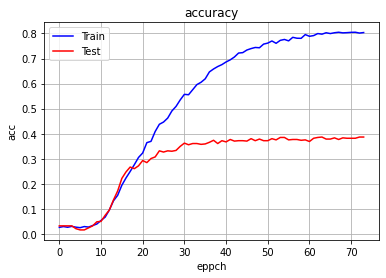

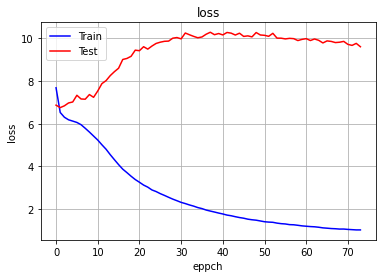

In [ ]:
# Тест
acc = hist.history['accuracy']
acc_v = hist.history['val_accuracy']
loss = hist.history['loss']
loss_v = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')
plt.xlabel('eppch')
plt.ylabel('acc')
plt.grid()
plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.xlabel('eppch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Строим тест генератора
########################################################
# начальная строка
seed_text = "Чипсы — это умение продать одну картофелину по цене килограмма"
#seed_text = "machine learning is true"
next_words = 10
# строим последовательность + новое предсказание  
for _ in range(next_words):
  # текущая последовательность (токенизация и дополнение)
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding = 'pre')
  # делаем предсказание (сразу как индекс класса - у нас 1 из 3211)
  predicted = model.predict(token_list, verbose=0)
  predict_ = np.argmax(predicted)
  output_word = ""
  print(predict_)
  # добавим новое слово в последовательность
  for word, index in tokenizer.word_index.items():
    if index == predict_:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

[4, 101, 22]
49
[4, 101, 22, 49]
69
[4, 101, 22, 49, 69]
327
[4, 101, 22, 49, 69, 327]
221
[4, 101, 22, 49, 69, 327, 221]
4
[4, 101, 22, 49, 69, 327, 221, 4]
6
[4, 101, 22, 49, 69, 327, 221, 4, 6]
136
[4, 101, 22, 49, 69, 327, 221, 4, 6, 136]
60
[4, 101, 22, 49, 69, 327, 221, 4, 6, 136, 60]
1190
[4, 101, 22, 49, 69, 327, 221, 4, 6, 136, 60, 1190]
94
Чипсы — это умение продать одну картофелину по цене килограмма там диво ходит ненастный — а потом три высоты глаз


In [ ]:
y_p=model.predict(token_list)

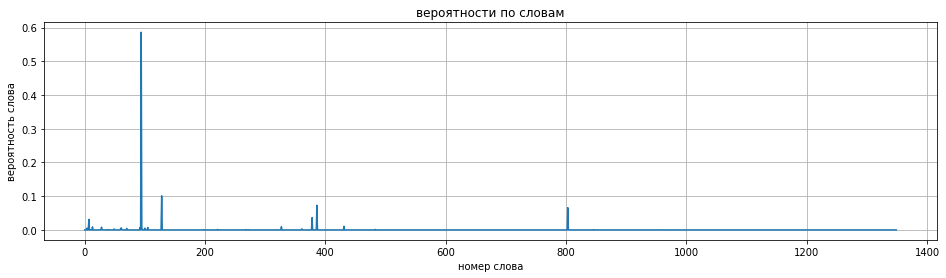

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

In [ ]:
ind_prob=np.where(y_p[0,:]>0.02)[0]
ind_prob

array([  7,  94, 128, 378, 386, 803])

In [ ]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

не  :  0.031376723
глаз  :  0.5862763
стоит  :  0.10107996
далёко  :  0.036411244
дочь  :  0.07305513
дня  :  0.06593627


In [ ]:
seed_text = "Чипсы — это умение продать одну картофелину по цене килограмма"
#seed_text = "She is my girl, I see in"
next_words = 20
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding='pre')
  #predicted = model.predict_classes(token_list, verbose=0)
  output_word = ""
  y_p = model.predict(token_list)
  y_predict = y_p * np.random.random(  size = (1,y_p.shape[1]))
  predicted_ind = np.argmax(y_predict,axis = 1)
  for word, index in tokenizer.word_index.items():
    if index == predicted_ind:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

[4, 101, 22]
[4, 101, 22, 49]
[4, 101, 22, 49, 69]
[4, 101, 22, 49, 69, 403]
[4, 101, 22, 49, 69, 403, 9]
[4, 101, 22, 49, 69, 403, 9, 4]
[4, 101, 22, 49, 69, 403, 9, 4, 328]
[4, 101, 22, 49, 69, 403, 9, 4, 328, 328]
[4, 101, 22, 49, 69, 403, 9, 4, 328, 328, 327]
[4, 101, 22, 49, 69, 403, 9, 4, 328, 328, 327, 39]
[4, 101, 22, 49, 69, 403, 9, 4, 328, 328, 327, 39, 328]
[4, 101, 22, 49, 69, 403, 9, 4, 328, 328, 327, 39, 328, 5]
[4, 101, 22, 49, 69, 403, 9, 4, 328, 328, 327, 39, 328, 5, 1106]
[4, 101, 22, 49, 69, 403, 9, 4, 328, 328, 327, 39, 328, 5, 1106, 384]
[4, 101, 22, 49, 69, 403, 9, 4, 328, 328, 327, 39, 328, 5, 1106, 384, 248]
[4, 101, 22, 49, 69, 403, 9, 4, 328, 328, 327, 39, 328, 5, 1106, 384, 248, 963]
[4, 101, 22, 49, 69, 403, 9, 4, 328, 328, 327, 39, 328, 5, 1106, 384, 248, 963, 963]
[4, 101, 22, 49, 69, 403, 9, 4, 328, 328, 327, 39, 328, 5, 1106, 384, 248, 963, 963, 38]
[4, 101, 22, 49, 69, 403, 9, 4, 328, 328, 327, 39, 328, 5, 1106, 384, 248, 963, 963, 38, 38]
[4, 101, 22, 

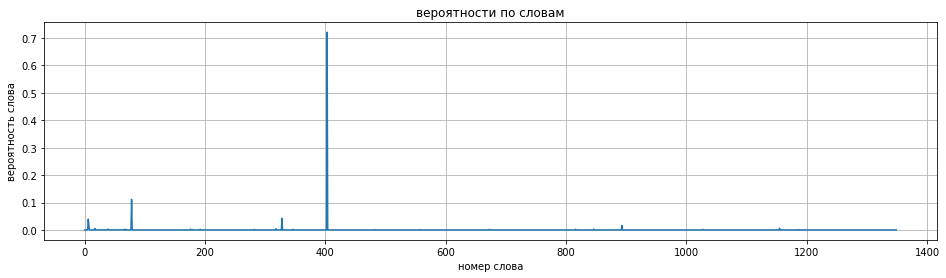

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

In [ ]:
ind_prob=np.where(y_p[0,:]>0.04)[0]
ind_prob

array([ 78, 328, 403])

In [ ]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

но  :  0.111622855
сводит  :  0.042741552
молвил  :  0.7211812


In [ ]:
# Функции потерь, оптимизаторы и размеры 'batch_size' для нахождения оптимальных параметров
losses = ['categorical_crossentropy', 'kullback_leibler_divergence']
optimizers = ['RMSProp','adam','NAdam']
batch_size = [2048, 1024, 512, 256, 128, 64]

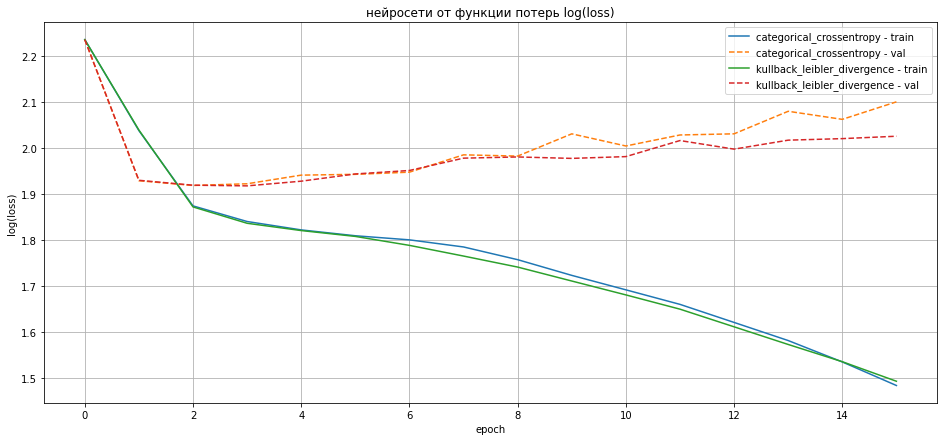

In [ ]:
# Создаем сети с разными функциями потерь
##########################################
plt.figure(figsize=(16,7))

# число рабочих эпох
epochs = 15

# вектор для выводoв результатов
epoch = np.arange(epochs+1)

# список словарей с историей по каждой нейронной сети в цикле
hh_2_list = []

# будем изменять функцию потерь
for i_los in losses:
  # создаем модель model_2
  model_2 = Sequential()
  model_2.add(Embedding(total_words, 256, input_length = max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
  # на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
 
  model_2.add(LSTM(128 ))
  model_2.add(Dropout( 0.2))
  model_2.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
  model_2.add(Dense(total_words, activation = 'softmax'))

  # сохраняем ее веса (это начальная точка) model_2.save_weights('model_2.h5')
  model_2.save_weights('model_2.h5')

  # создаем рабочую модель model_i куда будем загружать эти весa (она должна быть идентичной структуры)
  model_i = Sequential()
  model_i.add(Embedding(total_words, 256, input_length = max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
  # на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
  
  model_i.add(LSTM(128 ))
  model_i.add(Dropout( 0.2))
  model_i.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
  model_i.add(Dense(total_words, activation = 'softmax'))
  
  # загружаем веса model_i.load_weights('model_2.h5')
  model_i.load_weights('model_2.h5')
  # компилируем model_i с разными функциями потерь
  model_i.compile(
      optimizer='adam',
      loss=i_los,
      metrics=['accuracy'],
      )
  # вычисляем ошибку для model_i без обучения
  hh0_i_tr = model_i.evaluate(predictors[:2470,:], label[:2470],verbose = 0)
  hh0_i_val = model_i.evaluate(predictors[2470:,:], label[2470:],verbose = 0)
  # проводим обучение модели 
  hh_2 = model_i.fit(
                  predictors,
                  label,
                  epochs=epochs,
                  validation_split=0.2,
                  callbacks=[callback],
                  verbose = 0
                  ) 
  # фиксируем для тренировочного и тестового набора историю, в том числе и метрики accuracy
  hh_2_list.append(hh_2.history)
  # картинки
  plt.plot(epoch,np.log([hh0_i_tr[0]]+hh_2.history['loss']),'-', label = i_los +' - train')
  plt.plot(epoch,np.log([hh0_i_val[0]]+hh_2.history['val_loss']),'--', label = i_los + ' - val')
plt.legend()
plt.grid('On')

plt.title('нейросети от функции потерь log(loss)')
plt.xlabel('epoch')
plt.ylabel('log(loss)')
plt.show()

In [ ]:
# создание двумерного массива из зафиксированных в истории данных по 'accuracy' и 'val_accuracy' по каждой сети
ac_list_2 = []
for n in range(2):
  ac, v_ac = hh_2_list[n]['accuracy'][-1], hh_2_list[n]['val_accuracy'][-1]
  temp_list = [ac, v_ac]
  ac_list_2.append(temp_list)
ac_list_2

[[0.14939270913600922, 0.14886730909347534],
 [0.13967610895633698, 0.15695792436599731]]

__Вывод:__

Лучшие показатели точности получены с 'categorical_crossentropy' в качестве функции потерь.

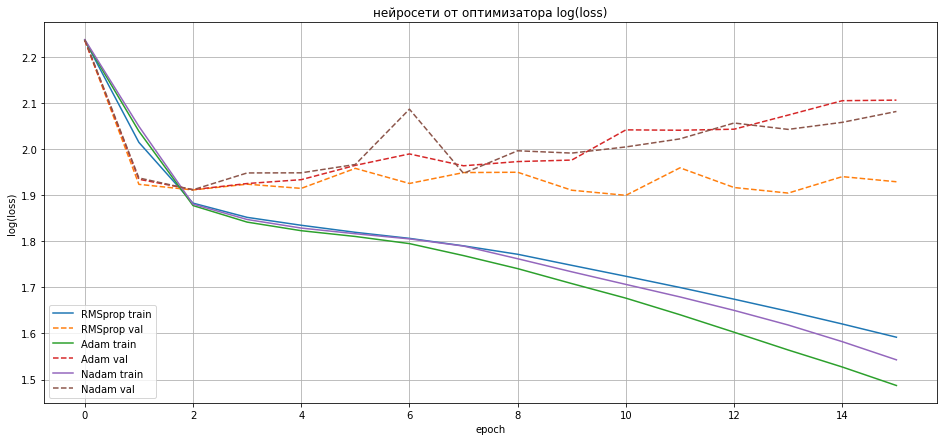

In [ ]:
# Создаем сети с разными оптимизаторами
##########################################
plt.figure(figsize=(16,7))

# число рабочих эпох
epochs = 15

# вектор для выводoв результатов
epoch = np.arange(epochs+1)

# список словарей с историей по каждой нейронной сети в цикле
hh_3_list = []

# будем изменять функцию потерь
for i_opt in optimizers:
  # создаем модель model_3
  model_3 = Sequential()
  model_3.add(Embedding(total_words, 256, input_length = max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
  # на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
  
  model_3.add(LSTM(128 ))
  model_3.add(Dropout( 0.2))
  model_3.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
  model_3.add(Dense(total_words, activation = 'softmax'))

  # сохраняем ее веса (это начальная точка) model_3.save_weights('model_3.h5')
  model_3.save_weights('model_3.h5')

  # создаем рабочую модель model_j куда будем загружать эти весa (она должна быть идентичной структуры)
  model_j = Sequential()
  model_j.add(Embedding(total_words, 256, input_length = max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
  # на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
  
  model_j.add(LSTM(128 ))
  model_j.add(Dropout( 0.2))
  model_j.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
  model_j.add(Dense(total_words, activation = 'softmax'))
  
  # загружаем веса model_j.load_weights('model_3.h5')
  model_j.load_weights('model_3.h5')
  # компилируем model_j с разными оптимизаторами
  model_j.compile(
      optimizer=i_opt,
      loss='categorical_crossentropy',
      metrics=['accuracy'],
      )
  # вычисляем ошибку для model_j без обучения
  hh0_j_tr = model_j.evaluate(predictors[:2470,:], label[:2470],verbose = 0)
  hh0_j_val = model_j.evaluate(predictors[2470:,:], label[2470:],verbose = 0)
  # проводим обучение модели 
  hh_3 = model_j.fit(
                  predictors,
                  label,
                  epochs=epochs,
                  validation_split=0.2,
                  callbacks=[callback],
                  verbose = 0
                  ) 
  # фиксируем для тренировочного и тестового набора историю, в том числе и метрики accuracy
  hh_3_list.append(hh_3.history)
  # картинки
  plt.plot(epoch,np.log([hh0_j_tr[0]]+hh_3.history['loss']),'-', label = model_j.optimizer.get_config()['name']+' train')
  plt.plot(epoch,np.log([hh0_j_val[0]]+hh_3.history['val_loss']),'--', label = model_j.optimizer.get_config()['name']+' val')
plt.legend()
plt.grid('On')

plt.title('нейросети от оптимизатора log(loss)')
plt.xlabel('epoch')
plt.ylabel('log(loss)')
plt.show()

In [ ]:
# создание двумерного массива из зафиксированных в истории данных по 'accuracy' и 'val_accuracy' по каждой сети
ac_list_3 = []
for n in range(3):
  ac, v_ac = hh_3_list[n]['accuracy'][-1], hh_3_list[n]['val_accuracy'][-1]
  temp_list = [ac, v_ac]
  ac_list_3.append(temp_list)
ac_list_3

[[0.07692307978868484, 0.08414239436388016],
 [0.12672065198421478, 0.15048544108867645],
 [0.10526315867900848, 0.07605177909135818]]

__Вывод:__

Лучшие показатели точности получены с оптимизатором 'adam'.

In [34]:
# Создаем сети с разными размерами 'batch_size'
###############################################

# число рабочих эпох
epochs = 15

# вектор для выводoв результатов
epoch = np.arange(epochs+1)

# список словарей с историей по каждой нейронной сети в цикле
hh_4_list = []

# будем изменять функцию потерь
for i_batch in batch_size:
  # создаем модель model_4
  model_4 = Sequential()
  model_4.add(Embedding(total_words, 256, input_length = max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
  # на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
  
  model_4.add(LSTM(128 ))
  model_4.add(Dropout( 0.2))
  model_4.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
  model_4.add(Dense(total_words, activation = 'softmax'))

  # сохраняем ее веса (это начальная точка) model_4.save_weights('model_4.h5')
  model_4.save_weights('model_4.h5')

  # создаем рабочую модель model_k куда будем загружать эти весa (она должна быть идентичной структуры)
  model_k = Sequential()
  model_k.add(Embedding(total_words, 256, input_length = max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
  # на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
 
  model_k.add(LSTM(128 ))
  model_k.add(Dropout( 0.2))
  model_k.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
  model_k.add(Dense(total_words, activation = 'softmax'))
  
  # загружаем веса model_k.load_weights('model_4.h5')
  model_k.load_weights('model_4.h5')
  # компилируем model_k 
  model_k.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy'],
      )

  # проводим обучение модели c разными размерами batch_size
  hh_4 = model_k.fit(
                  predictors,
                  label,
                  epochs=epochs,
                  batch_size=i_batch,
                  validation_split=0.2,
                  callbacks=[callback],
                  verbose = 0
                  ) 
  # фиксируем для тренировочного и тестового набора историю, в том числе и метрики accuracy
  hh_4_list.append(hh_4.history)

In [36]:
# создание двумерного массива из зафиксированных в истории данных по 'accuracy' и 'val_accuracy' по каждой сети
ac_list_4 = []
for n in range(6):
  ac, v_ac = hh_4_list[n]['accuracy'][-1], hh_4_list[n]['val_accuracy'][-1]
  temp_list = [ac, v_ac]
  ac_list_4.append(temp_list)
ac_list_4

[[0.030364371836185455, 0.03236246109008789],
 [0.030364371836185455, 0.03236246109008789],
 [0.030364371836185455, 0.03236246109008789],
 [0.027935221791267395, 0.03236246109008789],
 [0.04372469708323479, 0.029126213863492012],
 [0.043319836258888245, 0.025889968499541283]]

__Вывод:__

Лучшие показатели точности получены с размерами 'batch_size': 128.

In [54]:
# Строим итоговую модель
#####################################
callback = EarlyStopping( monitor = 'val_accuracy', patience = 10) # создаем обратный вызов - calback - тут "Ранний останов"

model_f = Sequential()
model_f.add(Embedding(total_words, 256, input_length = max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный

model_f.add(LSTM(128 ))
model_f.add(Dropout( 0.2))
model_f.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model_f.add(Dense(total_words, activation = 'softmax'))
model_f.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [55]:
# Обучим модель
hist_f = model_f.fit(predictors, label, epochs=100, batch_size=128, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/100
20/20 [==============================] - 3s 32ms/step - loss: 8.6681 - accuracy: 0.0219 - val_loss: 7.6854 - val_accuracy: 0.0324
Epoch 2/100
20/20 [==============================] - 0s 9ms/step - loss: 7.3397 - accuracy: 0.0304 - val_loss: 7.3622 - val_accuracy: 0.0324
Epoch 3/100
20/20 [==============================] - 0s 9ms/step - loss: 6.8374 - accuracy: 0.0304 - val_loss: 7.1968 - val_accuracy: 0.0324
Epoch 4/100
20/20 [==============================] - 0s 9ms/step - loss: 6.5862 - accuracy: 0.0304 - val_loss: 7.1400 - val_accuracy: 0.0324
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 6.4175 - accuracy: 0.0271 - val_loss: 7.0619 - val_accuracy: 0.0324
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 6.2939 - accuracy: 0.0300 - val_loss: 7.2131 - val_accuracy: 0.0324
Epoch 7/100
20/20 [==============================] - 0s 8ms/step - loss: 6.1966 - accuracy: 0.0304 - val_loss: 7.1757 - val_accuracy: 0.0324
Epoch 8/100


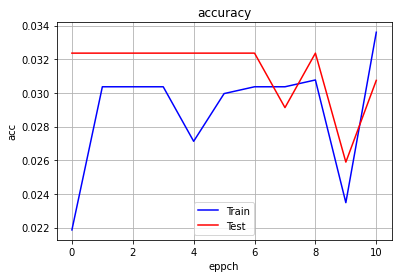

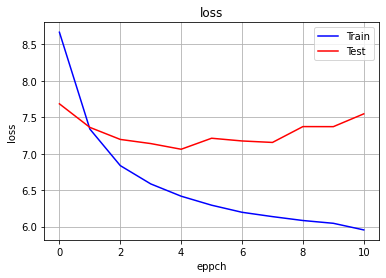

In [56]:
# Тест
acc_f = hist_f.history['accuracy']
acc_v_f = hist_f.history['val_accuracy']
loss_f = hist_f.history['loss']
loss_v_f = hist_f.history['val_loss']

epochs = range(len(acc_f))

plt.plot(epochs, acc_f, 'b', label='Train')
plt.plot(epochs, acc_v_f, 'r', label='Test')
plt.legend()
plt.title('accuracy')
plt.xlabel('eppch')
plt.ylabel('acc')
plt.grid()
plt.figure()

plt.plot(epochs, loss_f, 'b', label='Train')
plt.plot(epochs, loss_v_f, 'r', label='Test')
plt.title('loss')
plt.xlabel('eppch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

In [68]:
# Тecт генератора
###################
seed_text = "Чипсы — это умение продать одну картофелину по цене килограмма"
next_words = 20
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding='pre')
  
  output_word = ""
  y_p = model_f.predict(token_list)
  y_predict = y_p * np.random.random(  size = (1,y_p.shape[1]))
  predicted_ind = np.argmax(y_predict,axis = 1)
  for word, index in tokenizer.word_index.items():
    if index == predicted_ind:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

[4, 101, 22]
[4, 101, 22, 2]
[4, 101, 22, 2, 14]
[4, 101, 22, 2, 14, 52]
[4, 101, 22, 2, 14, 52, 312]
[4, 101, 22, 2, 14, 52, 312, 90]
[4, 101, 22, 2, 14, 52, 312, 90, 312]
[4, 101, 22, 2, 14, 52, 312, 90, 312, 29]
[4, 101, 22, 2, 14, 52, 312, 90, 312, 29, 376]
[4, 101, 22, 2, 14, 52, 312, 90, 312, 29, 376, 434]
[4, 101, 22, 2, 14, 52, 312, 90, 312, 29, 376, 434, 7]
[4, 101, 22, 2, 14, 52, 312, 90, 312, 29, 376, 434, 7, 52]
[4, 101, 22, 2, 14, 52, 312, 90, 312, 29, 376, 434, 7, 52, 312]
[4, 101, 22, 2, 14, 52, 312, 90, 312, 29, 376, 434, 7, 52, 312, 384]
[4, 101, 22, 2, 14, 52, 312, 90, 312, 29, 376, 434, 7, 52, 312, 384, 48]
[4, 101, 22, 2, 14, 52, 312, 90, 312, 29, 376, 434, 7, 52, 312, 384, 48, 434]
[4, 101, 22, 2, 14, 52, 312, 90, 312, 29, 376, 434, 7, 52, 312, 384, 48, 434, 12]
[4, 101, 22, 2, 14, 52, 312, 90, 312, 29, 376, 434, 7, 52, 312, 384, 48, 434, 12, 14]
[4, 101, 22, 2, 14, 52, 312, 90, 312, 29, 376, 434, 7, 52, 312, 384, 48, 434, 12, 14, 52]
[4, 101, 22, 2, 14, 52, 312, 9

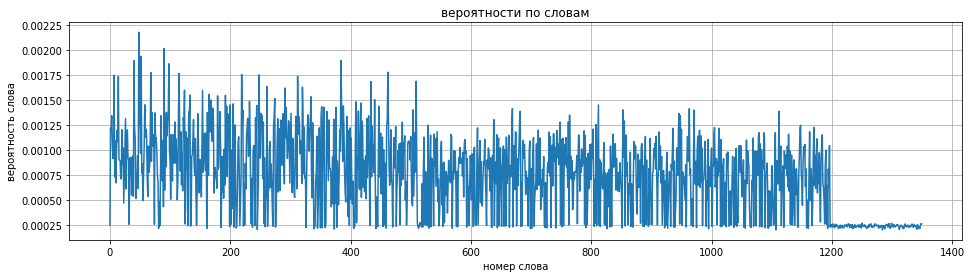

In [69]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

In [70]:
ind_prob=np.where(y_p[0,:]>0.00175)[0]
ind_prob

array([ 40,  48,  52,  68,  90,  98, 115, 219, 248, 384, 462])

In [71]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

морю  :  0.0018951932
сватьей  :  0.0021800508
моря  :  0.0019395358
белка  :  0.0017774107
ними  :  0.0020168223
ней  :  0.0018641326
велят  :  0.0017683037
прекрасный  :  0.0017566622
всем  :  0.001753136
слова  :  0.0018977469
весть  :  0.0017794654


__Вывод:__

После изменения 'batch_size' генерация текста моделью немного улучшилась